# Приступим

In [1]:
import string
import pandas as pd
import numpy as np
import urllib
from sqlalchemy import create_engine
import glob
import datetime
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

SQLServer = 'sql-mt01' 
cash_sales = 'DWH'

#Прописываем строку подключения к базе
paramsDWH = urllib.parse.quote_plus('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SQLServer+';DATABASE='+cash_sales+';Trusted_Connection=yes')
#Создаем SQL движок
engineDWH = create_engine("mssql+pyodbc:///?odbc_connect=%s" % paramsDWH)

#Получаем месяцы из DWH

data_2 = pd.read_sql_query('select * from t_s_arima', engineDWH)


In [10]:
data_2.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1591 entries, 2021-11-08 to 2020-08-23
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   9lcases  1591 non-null   float64
dtypes: float64(1)
memory usage: 24.9 KB


In [9]:
data_2.describe()

,9lcases
count,1591.000000
mean,26254.895611
std,13084.135027
min,-245.298119
25%,16670.976924
50%,26138.823691
75%,34876.903444
max,93323.431421


In [7]:
data_2.columns = data_2.columns.str.lower()

In [11]:
data_2.set_index('findate', inplace=True)

KeyError: "None of ['findate'] are in the columns"

In [164]:
#data_3 = data_2.resample('1W').sum()

data_3 = data_2.resample('W-MON').sum()


In [165]:
data_3.head(10)

,9lcases
findate,
2019-01-07,19276.333524
2019-01-14,83490.614188
2019-01-21,120329.173524
2019-01-28,155820.037535
2019-02-04,147426.815254
2019-02-11,173629.352591
2019-02-18,163375.975069
2019-02-25,150775.063788
2019-03-04,189933.085593


In [166]:
data_sarima = data_3

In [167]:
data_sarima.head()

,9lcases
findate,
2019-01-07,19276.333524
2019-01-14,83490.614188
2019-01-21,120329.173524
2019-01-28,155820.037535
2019-02-04,147426.815254


In [168]:
data_sarima.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 228 entries, 2019-01-07 to 2023-05-15
Freq: W-MON
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   9lcases  228 non-null    float64
dtypes: float64(1)
memory usage: 3.6 KB


In [169]:
data_sarima = data_sarima.sort_index()

In [170]:
print(data_sarima.index.is_monotonic)

True


In [171]:
print (data_sarima.index.min(), data_sarima.index.max())

2019-01-07 00:00:00 2023-05-15 00:00:00


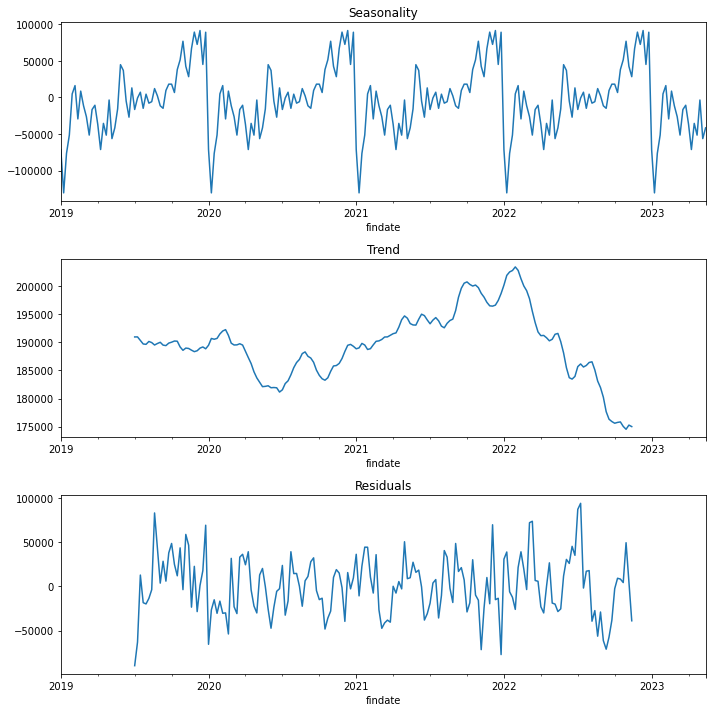

In [25]:
decomposed = seasonal_decompose(data_sarima)

plt.figure(figsize=(10, 10))
plt.subplot(311)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(312)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

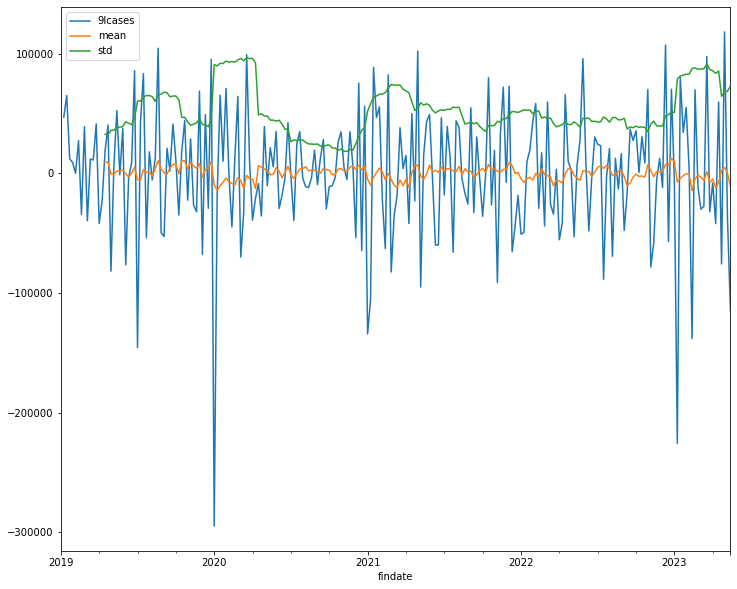

In [45]:
data1 = data_sarima - data_sarima.shift()
data1['mean'] = data1['9lcases'].rolling(15).mean()
data1['std'] = data1['9lcases'].rolling(15).std()
data1.plot(figsize=(12,10))
plt.show()

In [187]:
data_sarima = data_sarima.drop ('forecast',axis = 1)

In [188]:
# разделим выборки на обучающую и тестовую
train, test = train_test_split(data_sarima, shuffle=False, test_size=0.2)
train = train.dropna()

In [189]:
train

,9lcases
findate,
2019-01-07,19276.333524
2019-01-14,83490.614188
2019-01-21,120329.173524
2019-01-28,155820.037535
2019-02-04,147426.815254
...,...
2022-05-30,254314.521121
2022-06-06,246942.957247
2022-06-13,199218.905086


In [125]:
from pmdarima import auto_arima
sarimax_model = auto_arima(train, exogenous = train,
                         start_p = 0,
                         start_q = 0,
                         max_p = 5,
                         max_q = 5,
                         m = 52,
                         test = 'adf',
                         seosonal = True,
                         d = 1,
                         D = 1,
                         trace = True,
                         error_action = 'ignore',
                         suppress_warning = True,
                         stepwise = True
                          )
sarimax_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=inf, Time=1.43 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=3194.046, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=3159.707, Time=0.92 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=1.11 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=3178.417, Time=0.16 sec
 ARIMA(1,1,0)(2,1,0)[52]             : AIC=inf, Time=3.31 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=2.00 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=1.14 sec
 ARIMA(1,1,0)(2,1,1)[52]             : AIC=3143.702, Time=8.09 sec
 ARIMA(1,1,0)(2,1,2)[52]             : AIC=3145.654, Time=15.54 sec
 ARIMA(1,1,0)(1,1,2)[52]             : AIC=inf, Time=11.76 sec
 ARIMA(0,1,0)(2,1,1)[52]             : AIC=3151.337, Time=7.54 sec
 ARIMA(2,1,0)(2,1,1)[52]             : AIC=3137.059, Time=14.10 sec
 ARIMA(2,1,0)(1,1,1)[52]             : AIC=inf, Time=4.22 sec
 ARIMA(2,1,0)(2,1,0)[52]             : AIC=inf, Tim

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  182
Model:             SARIMAX(0, 1, 2)x(2, 1, [], 52)   Log Likelihood               -1560.587
Date:                             Fri, 12 May 2023   AIC                           3131.175
Time:                                     14:16:35   BIC                           3145.474
Sample:                                 01-06-2019   HQIC                          3136.985
                                      - 06-26-2022                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.2957      0.069     -4.310      0.000      -0.430      -0.161
ma.L2         -0.2182      0.097     -2.256      0.024      -0.408      -0.029
ar.S.L52      -0.5054      0.121     -4.164      0.000      -0.743      -0.268
ar.S.L104     -0.3897      0.133     -2.933      0.003      -0.650      -0.129
sigma2      2.324e+09   3.14e-11    7.4e+19      0.000    2.32e+09    2.32e+09
===================================================================================
Ljung-Box (L1) (Q):                   1.78   Jarque-Bera (JB):                 1.12
Prob(Q):                              0.18   Prob(JB):                         0.57
Heteroskedasticity (H):               1.40   Skew:                             0.02
Prob(H) (two-sided):                  0.27   Kurtosis:                         3.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.04e+35. Standard errors may be unstable.
"""

In [28]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [190]:
model = SARIMAX(train['9lcases'], exogenous = train, order = (3,1,3), seasonal_order = (2,1,0,52))
model_fit = model.fit()

C:\Users\dmitri.maruev\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\dmitri.maruev\Anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\dmitri.maruev\Anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [135]:
#model = SARIMAX(train['9lcases'], exogenous = train, order = (0,1,2), seasonal_order = (0,1,0,52))
#model_fit = model.fit()

In [226]:
predictions = model_fit.forecast(len(test['9lcases'])+33)
#predictions = pd.Series(predictions, index = test.index)

In [228]:
pr = pd.Series(data = predictions.values, index = predictions.index)

In [230]:
predictions.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 79 entries, 2022-07-04 to 2024-01-01
Freq: W-MON
Series name: predicted_mean
Non-Null Count  Dtype  
--------------  -----  
79 non-null     float64
dtypes: float64(1)
memory usage: 1.2 KB


In [231]:
pr.head(10)

2022-07-04    161884.302592
2022-07-11    213269.372354
2022-07-18    238366.976542
2022-07-25    195815.770470
2022-08-01    211898.368662
2022-08-08    232029.430374
2022-08-15    247069.249792
2022-08-22    264359.103571
2022-08-29    224265.157280
2022-09-05    241389.239086
Freq: W-MON, dtype: float64

In [232]:
data_n2 = data_sarima

data_n2 ['forecast'] = predictions

In [233]:
display(data_n2[data_n2.index>='2023-01-01'])

,9lcases,forecast
findate,,
2023-01-02,227455.082507,125225.166852
2023-01-09,56825.777538,110308.074546
2023-01-16,128598.456365,156583.271069
2023-01-23,165496.310297,172139.674378
2023-01-30,227137.653704,236240.904395
2023-02-06,200795.863726,234189.627041
2023-02-13,86514.996393,217693.669745
2023-02-20,155456.685765,225721.088128
2023-02-27,134603.648950,225370.930342


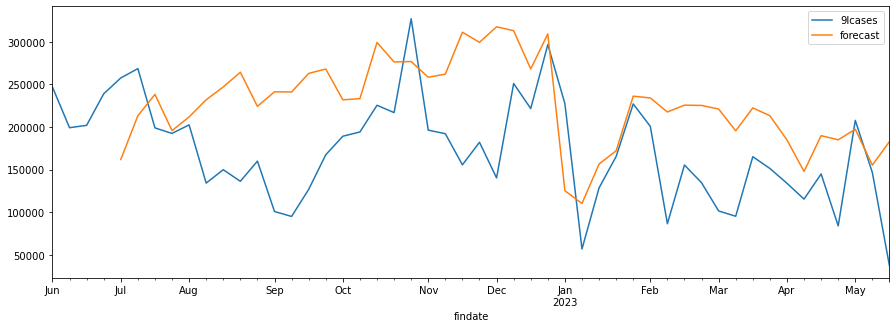

In [234]:
data_n2[data_n2.index>='2022-06-01'].plot(figsize=(15,5));

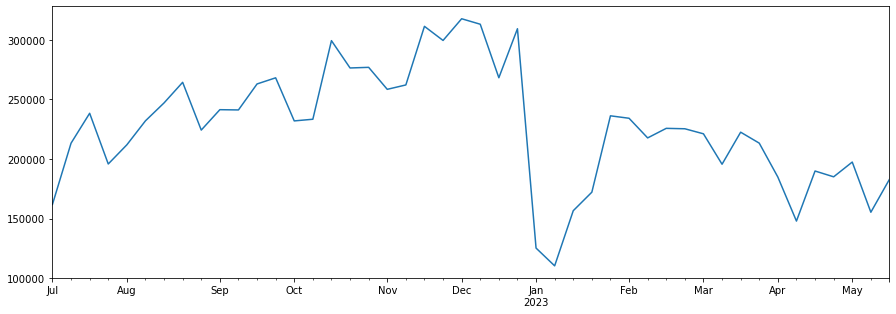

In [235]:
predictions[predictions.index<='2023-05-15'].plot(figsize=(15,5));

In [196]:
test.index

DatetimeIndex(['2022-07-04', '2022-07-11', '2022-07-18', '2022-07-25',
               '2022-08-01', '2022-08-08', '2022-08-15', '2022-08-22',
               '2022-08-29', '2022-09-05', '2022-09-12', '2022-09-19',
               '2022-09-26', '2022-10-03', '2022-10-10', '2022-10-17',
               '2022-10-24', '2022-10-31', '2022-11-07', '2022-11-14',
               '2022-11-21', '2022-11-28', '2022-12-05', '2022-12-12',
               '2022-12-19', '2022-12-26', '2023-01-02', '2023-01-09',
               '2023-01-16', '2023-01-23', '2023-01-30', '2023-02-06',
               '2023-02-13', '2023-02-20', '2023-02-27', '2023-03-06',
               '2023-03-13', '2023-03-20', '2023-03-27', '2023-04-03',
               '2023-04-10', '2023-04-17', '2023-04-24', '2023-05-01',
               '2023-05-08', '2023-05-15'],
              dtype='datetime64[ns]', name='findate', freq='W-MON')

In [203]:
predictions.to_csv('C:\\Users\dmitri.maruev\\Downloads\\my_csv__arima_3.csv')

In [202]:
train.to_csv('C:\\Users\dmitri.maruev\\Downloads\\my_csv__arima_2.csv')

In [204]:
data_sarima.to_csv('C:\\Users\dmitri.maruev\\Downloads\\my_csv__arima_4.csv')